In [1]:
from math import sqrt
import numpy as np
import matplotlib.path as mpl_path
import matplotlib.pyplot as plt
import pre_processing as pp
import csv
import pandas as pd
import tensorflow as tf
from point_grid import *

# Patch dataset gen - GH data

In [66]:
internal_count = 3
edge_count = 8
avg_quality = 0.67

df = pd.read_csv('data/8-gon-gh-dataset.csv')
# df = df[df.avgQuality > 0.65].dropna(axis=1, how='all')
df = df[df.avgQuality > avg_quality]
good_data = pd.isnull(df['dum1'])

df = df[good_data].dropna(axis=1, how='all')
dataset = df.drop(columns = 'avgQuality')


new_csv_path = "data/8-gon-patch-gh-3-internal.csv"
generate_patch_collection_and_write_to_csv(dataset, new_csv_path, edge_count=edge_count,internal_count=internal_count)


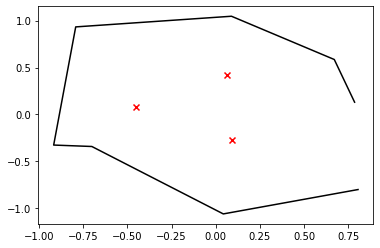

In [63]:
#==========================
#     Visualization
#==========================
max_row = dataset.iloc[2373].to_numpy()
mr_b = max_row[:-6]
mr_i = max_row[-6:]

bx, by = mr_b[::2], mr_b[1::2]
ix, iy = mr_i[::2], mr_i[1::2]

plt.plot(bx, by, 'k')
plt.scatter(ix, iy, c='r', marker='x')


# Patch dataset generation - gmsh data

In [ ]:
internal_count = 3
edge_count = 8


df = pd.read_csv('data/8-gon-correct-procrustes.csv')
df = df[df.internal_nodes == 3.0].dropna(axis=1, how='all')
df = df[df.target_edge_length == 0.4]
dataset = df.drop(['target_edge_length', 'internal_nodes'], axis=1)

# Csv-file to write to.
new_csv_path = "data/8-gon-patch-data-gmsh-3-internal.csv"
generate_patch_collection_and_write_to_csv(dataset, new_csv_path, edge_count=edge_count,internal_count=internal_count)

# Neural network 2: predicting internal node positions (or rather: predict grid score)

- 8 edges
- 3 internal nodes

In [10]:
# ======================
#        DATASET 
# ======================
import pandas as pd

patch_path = 'data/8-gon-patch-gh-3-internal.csv'
dataset = pd.read_csv(patch_path)

# Split dataset into 70/15/15 training/validation/test
patch_train = dataset.sample(frac=0.85)
patch_test = dataset.drop(patch_train.index)

# Split dataset into features and labels; last 4 (grid scores)
train_features = patch_train.iloc[:, :-4]
train_labels = patch_train.iloc[:, -4:]

test_features = patch_test.iloc[:, :-4]
test_labels = patch_test.iloc[:, -4:]

In [11]:
# packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

# ======================
#       MODEL STUFF
# ======================
INITIAL_LEARNING_RATE = 1e-3
EPOCHS = 5000
BATCH_SIZE = 512

model_path = 'model/thesis-grid-8gon-3int-gh'

def grid_model_setup(edge_count=8):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(edge_count*2+8,)),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(edge_count*2+4, activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(edge_count*2+4, activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(4),
    ])

    return model

model = grid_model_setup()
model.summary()

decay_steps= 10_000
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(1e-1, decay_steps, 1e-3)

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(
                  learning_rate=lr_schedule,
              ),
              )

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=EPOCHS//10, min_delta=0.0001)


history = model.fit(train_features,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.18,
                    verbose=2,
                    callbacks=[checkpoint, early_stopping],
                    )

# ======================
#       EVALUATION
# ======================
train_acc = model.evaluate(
    train_features, train_labels, verbose=0)
test_acc = model.evaluate(
    test_features, test_labels, verbose=0)
print('Training data loss: %.3f, Test data loss: %.3f' %
        (train_acc, test_acc))


807 - val_loss: 0.1613
Epoch 2336/5000
884/884 - 5s - loss: 0.1817 - val_loss: 0.1610
Epoch 2337/5000
884/884 - 5s - loss: 0.1802 - val_loss: 0.1615
Epoch 2338/5000
884/884 - 5s - loss: 0.1813 - val_loss: 0.1611
Epoch 2339/5000
884/884 - 5s - loss: 0.1812 - val_loss: 0.1613
Epoch 2340/5000
884/884 - 5s - loss: 0.1810 - val_loss: 0.1613
Epoch 2341/5000
884/884 - 5s - loss: 0.1806 - val_loss: 0.1618
Epoch 2342/5000
884/884 - 5s - loss: 0.1804 - val_loss: 0.1613
Epoch 2343/5000
884/884 - 5s - loss: 0.1807 - val_loss: 0.1615
Epoch 2344/5000
884/884 - 5s - loss: 0.1807 - val_loss: 0.1613
Epoch 2345/5000
884/884 - 5s - loss: 0.1803 - val_loss: 0.1611
Epoch 2346/5000
884/884 - 5s - loss: 0.1808 - val_loss: 0.1612
Epoch 2347/5000
884/884 - 5s - loss: 0.1813 - val_loss: 0.1611
Epoch 2348/5000
884/884 - 5s - loss: 0.1808 - val_loss: 0.1616
Epoch 2349/5000
884/884 - 5s - loss: 0.1810 - val_loss: 0.1616
Epoch 2350/5000
884/884 - 5s - loss: 0.1800 - val_loss: 0.1615
Epoch 2351/5000
884/884 - 6s - l

Text(0, 0.5, 'MSE')

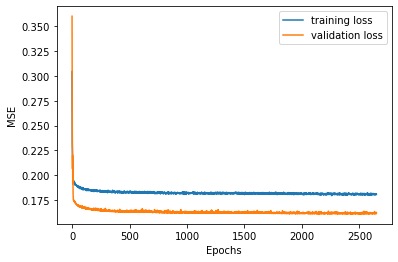

In [12]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
# plt.ylim(0.15, 0.24)

(0.15, 0.24)

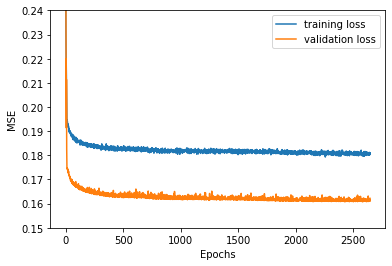

In [13]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.ylim(0.15, 0.24)

In [14]:
# ======================
#  EVALUATE SAVED MODEL 
# ======================

saved_model = tf.keras.models.load_model(model_path)

train_acc = saved_model.evaluate(
    train_features, train_labels, verbose=0)
test_acc = saved_model.evaluate(
    test_features, test_labels, verbose=0)
print('Training data loss: %.3f, Test data loss: %.3f' %
        (train_acc, test_acc))

Training data loss: 0.160, Test data loss: 0.159


# Stat gathering for nn2

1. Create random contour.
2. Find internal mesh points with gmsh, grid nn and direct nn.
3. Calculate how often grid/direct is outside, and the mean euclidean error.

In [22]:
# Pre-processing method for nn2. 
def stat_grid_prediction_pipeline(contour, internal_node_count, grid_model):

    # Build point grid
    point_grid = generate_point_grid()
    patches = generate_patches(point_grid)

    # Pre-process contour with procrustes superimposition
    transformed_contour = pp.procrustes(contour)['transformed_contour'] 
    transformed_contour_data = [coordinate for point in transformed_contour for coordinate in point]

    # Get patch data
    for patch in patches:
        patch_data = [coordinate for point in patch for coordinate in point.get_coordinates()]

        # Define prediction data
        features = np.append(transformed_contour_data, patch_data)
        prediction_data = np.expand_dims(features, axis=0)

        # Predict
        prediction_result = grid_model(prediction_data).numpy()

        # Write predicted score to the point grid
        for i, p in enumerate(patch):
            p.score = prediction_result[0][i] 

    return point_grid

def stat_direct_prediction_pipeline(contour_input_2, direct_model):
    # Pre-process contour with procrustes superimposition
    transformed_contour_data = [coordinate for point in contour_input_2 for coordinate in point]

    # Load model
    

    # Define prediction data
    features = transformed_contour_data
    direct_prediction_data = np.expand_dims(features, axis=0)

    # Predict
    direct_prediction_result = direct_model(direct_prediction_data).numpy()

    return direct_prediction_result

def calc_dist_error(contour, predicted: list, reference: list) -> list:
    """
    Calculates the euclidean distance error of predictions. Assigns a negative value if point is outside of the contour.
    Calculates the distance to the _closest_point.
    """
    se_list = []
    # Define contour (for finding points inside)
    contour_path = mpl_path.Path(contour)

    for p_point in predicted:
        error = 100
        for r_point in reference:
            tmp_squared_error = sqrt((p_point[0] - r_point[0])**2 + (p_point[1] - r_point[1])**2)
            if tmp_squared_error < error:
                error = tmp_squared_error
        if contour_path.contains_point(p_point):
            se_list.append(error)
        else:
            se_list.append(-error)
    return se_list


def find_mean_and_worst_error_new(error_list):
    sum_e_worst = 0  # sum of the largest errors of each mesh
    sum_e_mean = 0  # sum of the mse of each mesh
    outside = 0   
    for mesh in error_list:
        # Negative values means predicted point was outside contour. Count it and make it positive.
        for i, point_error in enumerate(mesh):
            if point_error < 0:
                outside += 1
                mesh[i] = -point_error
        sum_e_worst += max(mesh)
        sum_e_mean += sum(mesh)/len(mesh)

    e_worst = sum_e_worst/len(error_list)
    e_mean = sum_e_mean/len(error_list)
    
    return [round(e_mean, 3), round(e_worst, 3), outside/len(error_list)]




from IPython.display import clear_output
import gmsh
import pre_processing as pp
from point_grid import *

# Initialization
target_internal_node_count = 3
edge_count = 8
sample_size = 1000
distance_error_grid = []
distance_error_direct = []

grid_model_path = 'model/thesis-grid-8gon-3int'
# direct_model_path = 'model/direct-internal-nodes-correct'
grid_model = tf.keras.models.load_model(grid_model_path)
# direct_model = tf.keras.models.load_model(direct_model_path)

gmsh.initialize()

for i in range(sample_size):
    clear_output(wait=True)
    print(f"Gathering stats on grid model: {grid_model_path} and direct model: {direct_model_path}")
    print("\r", f"processing contour {i+1} of {sample_size}", end="")

    # We only check contours that the reference mesher actually place two points inside of.
    # Target edge length: 0.4
    meshed_internal_node_count = -1
    
    while meshed_internal_node_count != target_internal_node_count:
        contour = pp.create_random_ngon(edge_count)
        transformed_contour = pp.procrustes(contour)['transformed_contour']

        meshed_contour = pp.mesh_contour(transformed_contour, 0.4)
        meshed_internal_points = meshed_contour[-target_internal_node_count*2:]
        meshed_internal_node_count = int(meshed_contour[2*edge_count+1])
    

    # Predict the point grid and intrapolate nodes from it.
    predicted_point_grid = stat_grid_prediction_pipeline(transformed_contour, target_internal_node_count, grid_model)
    grid_prediction = generate_internal_nodes_from_grid_score(predicted_point_grid, target_internal_node_count)

    # Direct prediction without point grid
    # direct_prediction_raw = stat_direct_prediction_pipeline(contour, direct_model)[0]
    # direct_prediction = list(zip(direct_prediction_raw[::2], direct_prediction_raw[1::2]))
    
    reference_nodes = list(zip(meshed_internal_points[::2], meshed_internal_points[1::2]))

    distance_error_grid.append(calc_dist_error(transformed_contour, grid_prediction, reference_nodes))
    # distance_error_direct.append(calc_dist_error(transformed_contour, direct_prediction, reference_nodes))

gmsh.finalize()

grid_prediction_stats = find_mean_and_worst_error_new(distance_error_grid)
# direct_prediction_stats = find_mean_and_worst_error_new(distance_error_direct)
grid_prediction_stats


Gathering stats on grid model: model/thesis-grid-8gon-3int and direct model: model/direct-internal-nodes-correct
 processing contour 1000 of 1000

[0.196, 0.292, 0.0]

In [8]:
grid_prediction_stats, direct_prediction_stats

([0.195, 0.252, 0.0], [0.217, 0.267, 0.0])

# Plotting

[(0.008322693756147675, 0.32347838722258615),
 (-0.5937370755006084, 0.13432833855881274),
 (0.45990068541968826, 0.06471191071484017)]

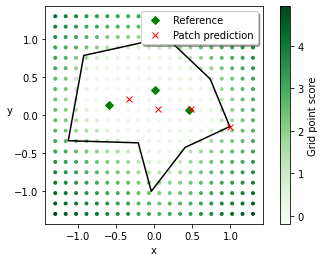

In [21]:
import gmsh

grid_model_path = 'model/thesis-grid-8gon-3int-gh'
gmsh.initialize()
grid_model = tf.keras.models.load_model(grid_model_path)

# Naive way of only checking the results on contours that the reference mesher would insert two points into
meshed_internal_node_count = -1
target_internal_node_count = 3
edge_count = 8
while meshed_internal_node_count != target_internal_node_count:
    contour = pp.create_random_ngon(edge_count)
    transformed_contour = pp.procrustes(contour)['transformed_contour']

    meshed_contour = pp.mesh_contour(transformed_contour, 0.4)
    meshed_internal_points = meshed_contour[-target_internal_node_count*2:]
    meshed_internal_node_count = int(meshed_contour[2*edge_count+1])

gmsh.finalize()

reference_nodes = list(zip(meshed_internal_points[::2], meshed_internal_points[1::2]))

# Predict the point grid and intrapolate nodes from it.
predicted_point_grid = stat_prediction_pipeline_nn2(transformed_contour, target_internal_node_count, grid_model)
grid_prediction = generate_internal_nodes_from_grid_score(predicted_point_grid, target_internal_node_count)

"""
|-------------------------
|       PLOTTING
|-------------------------
"""
flat_pgp = [point for row in predicted_point_grid for point in row]

pgp_x = [p.x for p in flat_pgp]
pgp_y = [p.y for p in flat_pgp]
pgp_s = [p.score for p in flat_pgp]

# Plot predicted points (green)
pl0 = plt.plot([x[0] for x in reference_nodes], [y[1] for y in reference_nodes], 'gD',
            label="Reference",
            )
pl1 = plt.plot([x[0] for x in grid_prediction], [y[1] for y in grid_prediction], 'rx', label="Patch prediction")
# Plot transformed contour
pl3 = pp.plot_polygon(transformed_contour, style='k')

# Plot point grid
pl4 = plt.scatter(pgp_x, pgp_y, c=pgp_s, cmap=plt.cm.Greens, marker='.')
plt.colorbar(label="Grid point score")
plt.legend(loc='upper right', shadow='true')
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.gca().set_aspect('equal')
reference_nodes